# House Price Analysis with Linear Regression

--------------------------------------------

The focus of this project will be centered around first time home buyers. 

## Data Cleaning
Data cleansing or data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


### Datetime

The "date" column is currently an object. Let's change it to datetime, then extract the month and year so we can use those easily. Then, drop the original date column.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

### Odd values 

In [7]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
946.0     0.000046
2400.0    0.000046
1816.0    0.000046
1525.0    0.000046
65.0      0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [8]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [9]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
862.0         1
1852.0        1
2240.0        1
1024.0        1
65.0          1
Name: sqft_basement, Length: 303, dtype: int64

In [10]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [11]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

Let's look elsewhere and see if there is anything else odd.

In [12]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969,2014.322962
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061,0.467619
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,2014.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,2014.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,2015.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,2015.000000


That house with 33 bedrooms is definitely odd. Let's check it out.

In [13]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960,8,2014
13301,627300145,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400,8,2014
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914,10,2014
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,6,2014
19239,8812401450,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745,12,2014


Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [15]:
# Drop the 33 bedroom house then verify that it is gone
df.drop(index=15710, inplace= True)
# df[df['bedrooms'] >= 10]

### Null values

In [16]:
# look at values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [17]:
# look at values in view
df.view.value_counts(normalize= True)

0.0    0.901918
2.0    0.044443
3.0    0.023592
1.0    0.015325
4.0    0.014722
Name: view, dtype: float64

In [18]:
# look at values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958094
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [19]:
df.fillna(0, inplace= True)

### Duplicates

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [20]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [21]:
df_id_dups = df[df.duplicated('id')]

In [22]:
df_id_dups.reset_index(drop= True, inplace= True)

In [23]:
df.loc[df['id'] == 6021501535]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
93,6021501535,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,7,2014
94,6021501535,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,12,2014


In [24]:
df.loc[df['id'] == 4139480200]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
313,4139480200,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,6,2014
314,4139480200,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,12,2014


In [25]:
df.loc[df['id'] == 3969300030]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
345,3969300030,165000.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,7,2014
346,3969300030,239900.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138,12,2014


It looks like the rows that have identical id numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [26]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [27]:
df.id.duplicated().sum()

0

In [28]:
df.reset_index(inplace= True, drop= True)

Great! We took care of duplicates, null values, odd values, and have correct data types.

We can move on to taking a closer look at the data.

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Data visualization is the graphical representation of data in order to interactively and efficiently convey insights to others.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21419 entries, 0 to 21418
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Questions?

Given the information we have and that we are looking at data that would be interesting to first time home buyers, let's generate some questions that might conclude some interesting answers.

1. Which season is best to buy a house if you want the lowest price?
2. Does a waterfront or view matter? Could a first time home buyer afford that?
3. Are there some grades or conditions that might be out of reach for a first time home buyer?
4. Is there an area that we can focus on or eliminate?

#### Criteria assumptions
Before we dive into those questions, it would be helpful to get rid of the information that is not pertinent to a first time home buyer. These could be things like:
* houses over a certain price
* houses with a large square footage
* houses with a lot of bedrooms
* older homes

So, let's work on removing the irrelevant data.

<AxesSubplot:xlabel='price'>

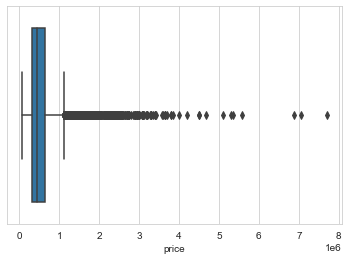

In [30]:
#  Visualize price and outliers
#  Assume for first time home buyer - budget is not more than $500,000
sns.boxplot(x= df['price'])

In [31]:
# remove houses that sold for > $500,000
df = df[df['price'] <= 500000]

<AxesSubplot:xlabel='sqft_living'>

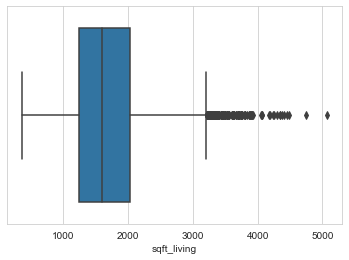

In [32]:
# Visualize houses with high square footage
sns.boxplot(x= df['sqft_living'])

In [33]:
# Whoa! Those are some large houses! Let's cut out the outliers
df = df[df['sqft_living'] <= 3100]

<AxesSubplot:xlabel='bedrooms'>

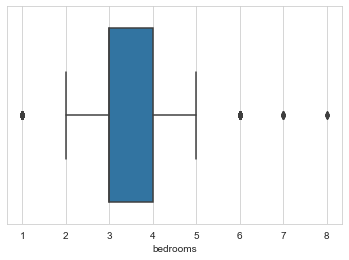

In [34]:
# Visualize bedrooms after houses with large price tags were removed
sns.boxplot(x= df['bedrooms'])

In [35]:
# remove houses with more than 5 bedrooms
df = df[df['bedrooms'] <= 5]

<AxesSubplot:xlabel='yr_built'>

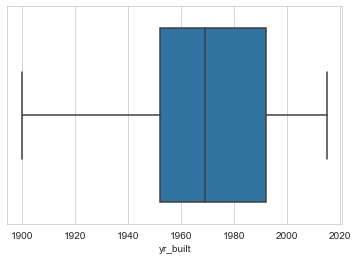

In [36]:
# Houses and the years they were built
sns.boxplot(x= df['yr_built'])

In [37]:
# First, let's look at houses that were built from 1900 - 1940 that
# had renovations since the year 2000
reno_1940 = len(df.loc[(df['yr_built'] <= 1940) & (df['yr_renovated'] >= 2000)])
print('# of houses built before 1940 that had renovation within 15 years:', 
      reno_1940)
print('% of houses that had recent reno and built before 1940: ',
     reno_1940 / len(df['yr_built']))

# of houses built before 1940 that had renovation within 15 years: 42
% of houses that had recent reno and built before 1940:  0.0034730836020838503


Only .3% of homes built in 1940 or before have been renovated. That is not enough to keep them around. Let's remove houses built before 1940 since they may require more repairs, renovations, and upkeep.

In [38]:
# Remove all homes older than 1940
df = df[df['yr_built'] >= 1940]

<AxesSubplot:xlabel='yr_built'>

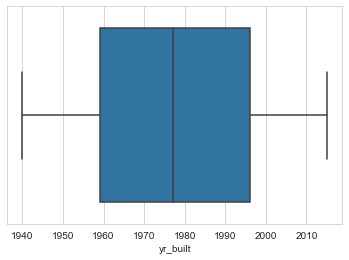

In [39]:
# check how it looks when older houses are out
sns.boxplot(x= df['yr_built'])

#### 1. Which season is best to buy a house if you want the lowest price?

To answer this question, we will have to break the months up into seasons. Then we will find which season has the lowest average sale price.

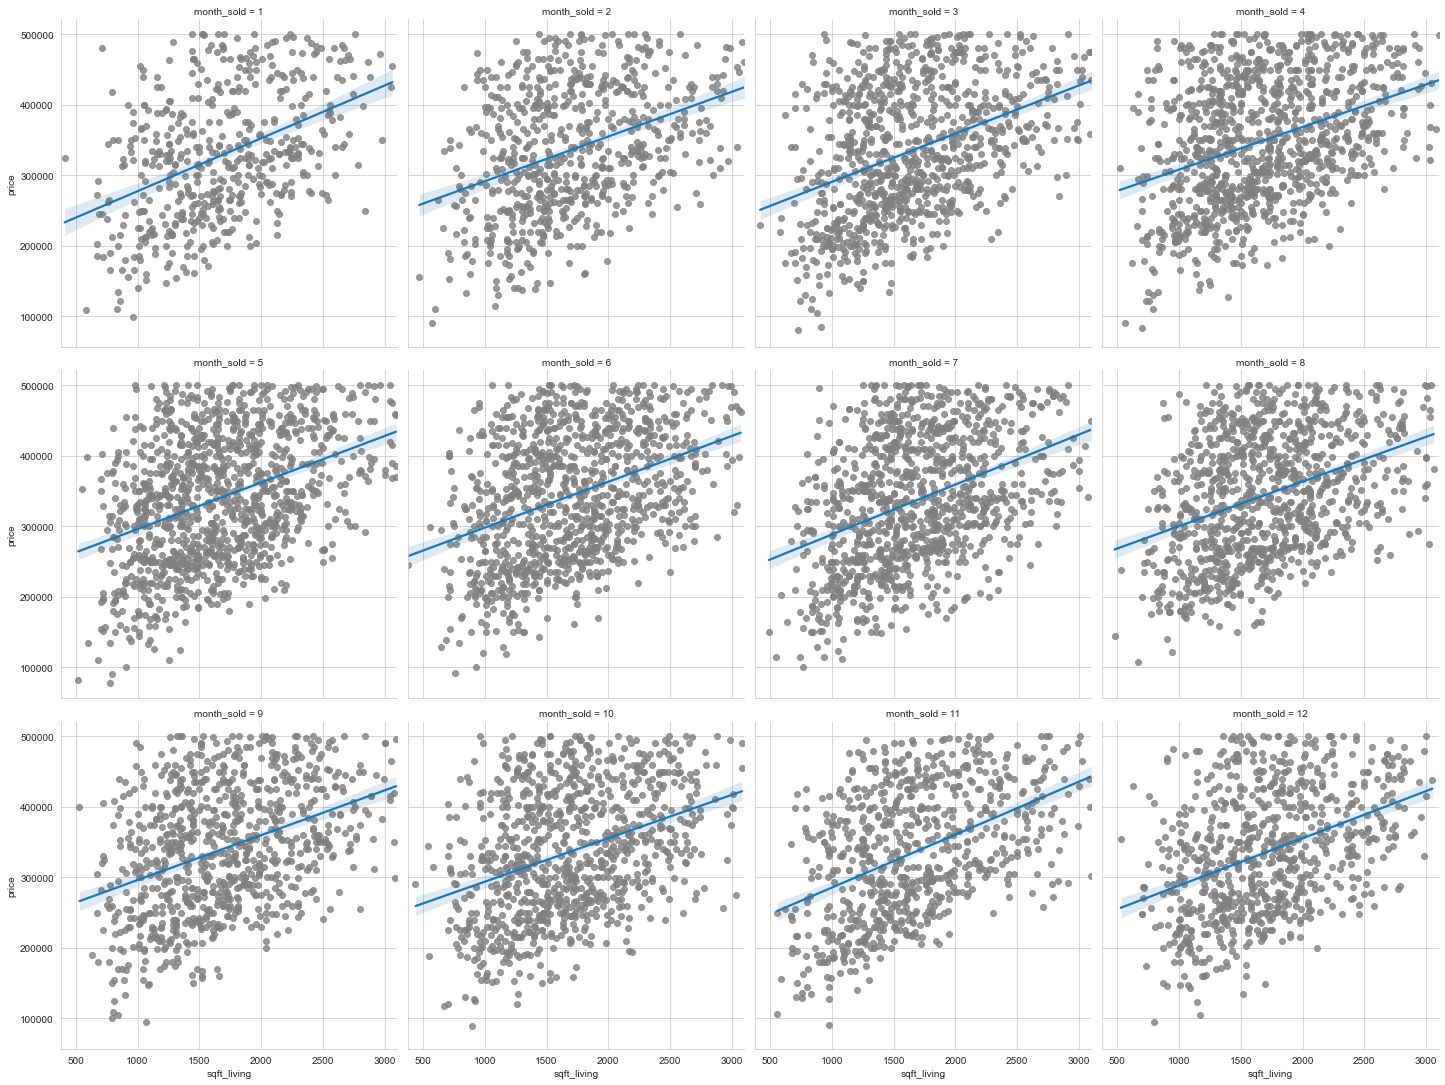

In [40]:
# First, let's look at the months and see if there appears to be a trend
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 4, scatter_kws = {'color': 'gray'})

In [41]:
# set columns for months sold
df.loc[(df['month_sold'] >= 4) & (df['month_sold'] <= 6), 'season'] = 'spring'
df.loc[(df['month_sold'] >= 7) & (df['month_sold'] <= 9), 'season'] = 'summer'
df.loc[(df['month_sold'] == 10) | (df['month_sold'] == 11), 'season'] = 'fall'
df.loc[(df['month_sold'] == 12), 'season'] = 'winter1'
df.loc[(df['month_sold'] <= 3), 'season'] = 'winter2'

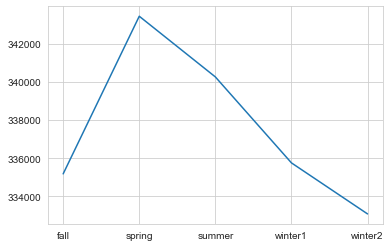

In [42]:
plt.plot(df.groupby('season')['price'].mean().round(2))

<AxesSubplot:xlabel='season', ylabel='price'>

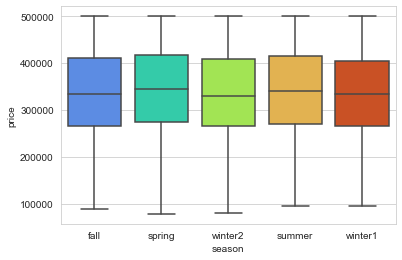

In [43]:
sns.boxplot(x= 'season', y= 'price', data= df, palette= 'turbo')

In [44]:
df_s = df.groupby('season')['price'].mean().round(2)
df_s

season
fall       335182.06
spring     343428.37
summer     340254.03
winter1    335756.45
winter2    333086.13
Name: price, dtype: float64

When comparing the line graph to the boxplot, you can now see that the amount you would be saving or spending is not that much. On average, the savings would be about $10,000 between the least expensive time of year (January - March) and the most expensive (April - June). Especially when compared to the cost of a house in the 300K range.

#### 2. Does a waterfront or view matter? Could a first time home buyer afford that?

Let's see how many waterfront properties or houses with views we have. When we took out higher priced homes, it may not have left much data in those features.

In [45]:
print(len(df[df['waterfront'] == 1]))
len(df[df['view'] > 0])

8


345

In [46]:
len(df[df['waterfront'] == 1]) / len(df)

0.0007494847292486415

There were only 8 properties that were sold in the first time home buyer's criteria. If they really want a waterfront property, they may have to wait a while.

In [47]:
len(df[df['view'] > 0]) / len(df)

0.03232152894884767

While 3% of the data is still a small portion, we can leave it and see what the analysis says.

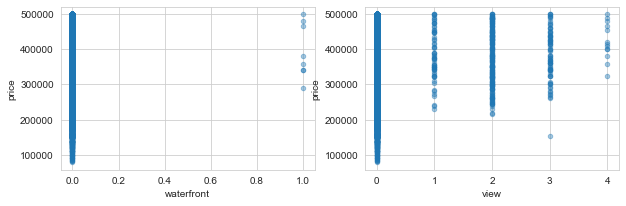

In [48]:
fig, axes = plt.subplots(nrows= 1, ncols= 2, figsize= (10, 3))

for xcol, ax in zip([ 'waterfront', 'view'], axes):
    df.plot(kind= 'scatter', x=xcol, y= 'price', ax=ax, alpha= 0.4)

Looks like getting a house with a view could still be a possibility. It appears that there are some houses priced around $250,000 that have a view rated "2"

#### 3. Are there some grades or conditions that might be out of reach for a first time home buyer?

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

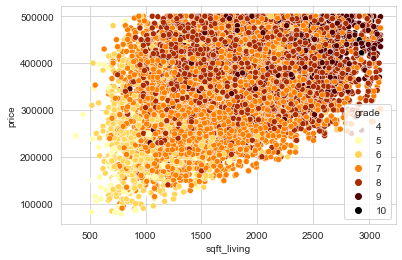

In [49]:
sns.scatterplot(x= 'sqft_living', y= 'price', hue= 'grade', data= df, 
                palette= 'afmhot_r')

Grades do seem to improve with price, but there are some smaller and less expensive homes that have higher grades.

0.0013115982761851227

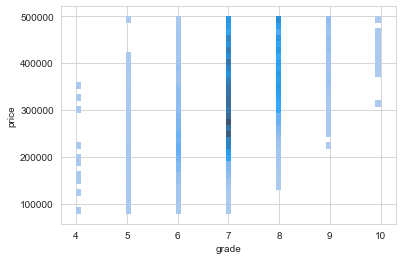

In [50]:
# #Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

# percent of houses sold with a grade "4"
len(df[df['grade'] == 4]) / len(df)

0.010399100618324901

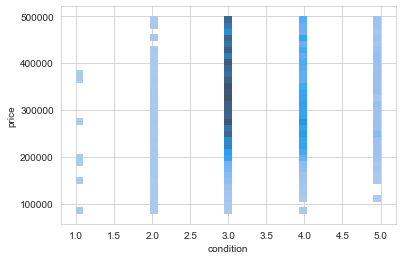

In [51]:
sns.histplot(x= 'condition', y= 'price', data= df)
# percent of houses with a condition of "1 or "2" 
len(df[df['condition'] <= 2]) / len(df)

In [52]:
df.condition.unique()

array([3, 4, 5, 2, 1])

While we may not want a first time home buyer to buy a house in poor condition, there are not many houses that would qualify. Since condition and grade can be subjective, we can leave them in and let the potential new home owner decide.

#### 4. Is there an area that we can focus on or eliminate?

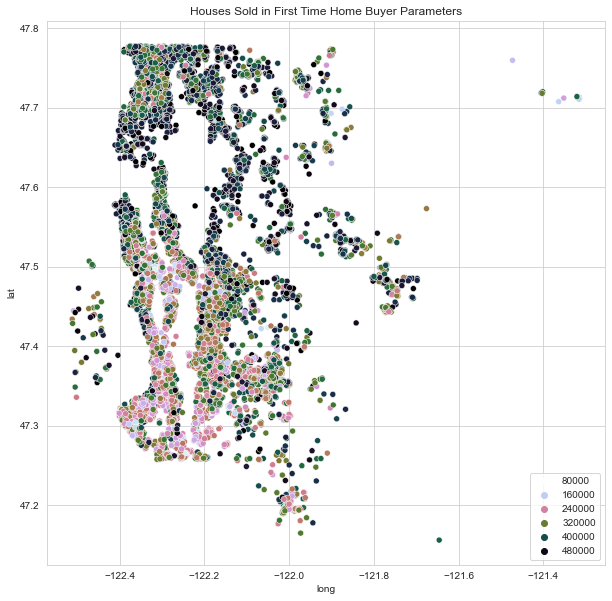

In [53]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix_r')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

Appears that the houses that sold for more are on the Northern side. We can separate the areas to see if we are correct.

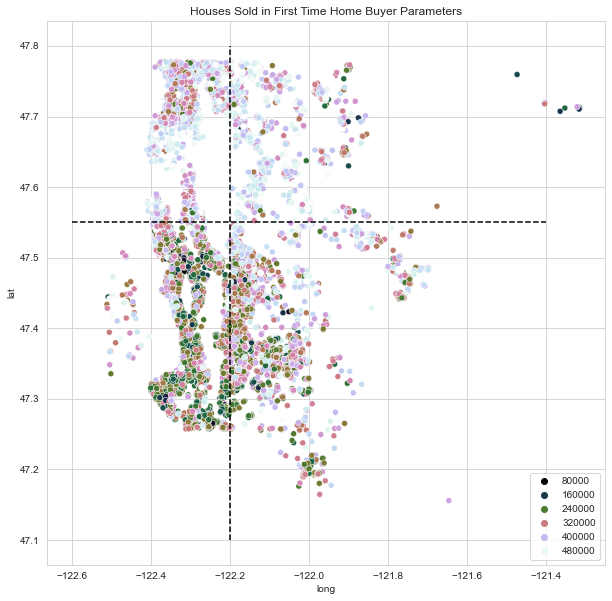

In [54]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette= 'cubehelix')
plt.hlines(y=47.55, xmin=-122.6, xmax=-121.4, colors='black', linestyle='--')
plt.vlines(x=-122.2, ymin=47.1, ymax=47.8, colors='black', linestyle='--')
plt.title('Houses Sold in First Time Home Buyer Parameters')
plt.legend(loc= 'lower right');

That appears to separate the areas fairly evenly. Let's turn the latitude and longitude into quadrants and use the quadrants instead of zipcodes as locators.

In [55]:
df.loc[(df['lat'] >= 47.5) & (df['long'] >= -122.2), 'quadrant' ] = 1
df.loc[(df['lat'] > 47.5) & (df['long'] < -122.2), 'quadrant' ] = 2
df.loc[(df['lat'] < 47.5) & (df['long'] < -122.2), 'quadrant' ] = 3
df.loc[(df['lat'] < 47.5) & (df['long'] > -122.2), 'quadrant' ] = 4

In [56]:
# did it work?
# df_q3 = df[df['quadrant'] == 3]
# sns.scatterplot(x='long', y='lat', hue='price', data=df_q3, 
#                 palette= 'cubehelix')

The theory is that houses in quadrants 3 and 4 will be more affordable than those in quadrants 1 and 2.

<AxesSubplot:xlabel='quadrant', ylabel='price'>

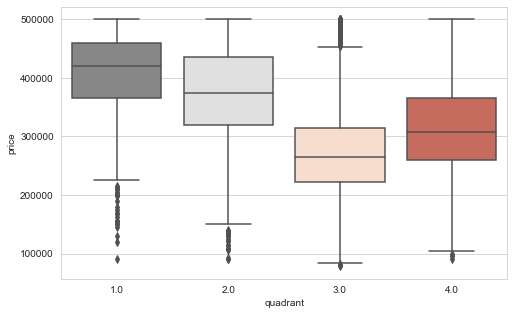

In [57]:
plt.figure(figsize= (8,5))
sns.boxplot(x= 'quadrant', y= 'price', data= df, palette= 'RdGy_r')

Looks like we were right. If we are only looking at homes that are less than $500,000, then houses in areas of quadrants 3 and 4 would be the least expensive.

## Feature Selection & Engineering

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

### Multicollinearity

Check for interactions between other features.

In [58]:
corr = df.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,quadrant
id,1.000000,0.008661,0.011794,0.043708,0.014318,-0.129567,0.033666,-0.016559,0.012980,-0.039670,0.045046,0.015164,-0.001188,0.051460,-0.012312,-0.007653,-0.014332,0.007132,-0.006157,-0.132660,-0.016154,0.016578,-0.041511
price,0.008661,1.000000,0.160011,0.344847,0.386168,0.074851,0.224742,0.016843,0.087676,-0.048987,0.418504,0.293959,0.163101,0.196679,0.006701,0.016381,0.494752,0.102704,0.341480,0.057062,0.000405,0.002946,-0.422919
bedrooms,0.011794,0.160011,1.000000,0.428291,0.609852,0.001219,0.061895,-0.024656,0.012639,0.037654,0.242038,0.455373,0.271168,0.134361,-0.013795,-0.160092,-0.165255,0.100652,0.375507,-0.004485,-0.001759,0.000083,0.158435
bathrooms,0.043708,0.344847,0.428291,1.000000,0.646650,-0.019253,0.515716,-0.020294,0.022458,-0.178532,0.538222,0.574654,0.150970,0.652814,-0.021417,-0.212174,-0.140441,0.185476,0.477434,-0.032767,0.020365,-0.021309,0.117504
sqft_living,0.014318,0.386168,0.609852,0.646650,1.000000,0.089119,0.241610,-0.013055,0.082536,-0.078743,0.539237,0.791879,0.378902,0.346114,-0.014409,-0.217956,-0.203676,0.198994,0.682666,0.088748,0.015172,-0.012316,0.193434
sqft_lot,-0.129567,0.074851,0.001219,-0.019253,0.089119,1.000000,-0.097194,0.015520,0.146919,0.030995,-0.009869,0.081082,0.019018,-0.063416,0.026361,-0.110711,-0.097139,0.201957,0.141601,0.750496,-0.001463,0.006533,0.087020
floors,0.033666,0.224742,0.061895,0.515716,0.241610,-0.097194,1.000000,-0.007744,-0.045526,-0.299712,0.414298,0.468829,-0.324584,0.687990,-0.033405,-0.050807,-0.009437,0.076455,0.185085,-0.104742,0.014303,-0.018320,0.016133
waterfront,-0.016559,0.016843,-0.024656,-0.020294,-0.013055,0.015520,-0.007744,1.000000,0.236954,0.011729,-0.016360,-0.012261,-0.001828,-0.028299,0.056418,0.018597,-0.015760,-0.043490,-0.003575,0.032161,0.015479,-0.011749,0.010428
view,0.012980,0.087676,0.012639,0.022458,0.082536,0.146919,-0.045526,0.236954,1.000000,0.019771,0.045433,0.013628,0.110675,-0.058017,0.008614,0.068179,-0.068312,-0.013648,0.116247,0.142076,0.012641,-0.007427,0.029075
condition,-0.039670,-0.048987,0.037654,-0.178532,-0.078743,0.030995,-0.299712,0.011729,0.019771,1.000000,-0.184179,-0.148961,0.098586,-0.337964,-0.032730,-0.056196,-0.060943,-0.013332,-0.123243,0.041630,0.015282,-0.033012,0.070129


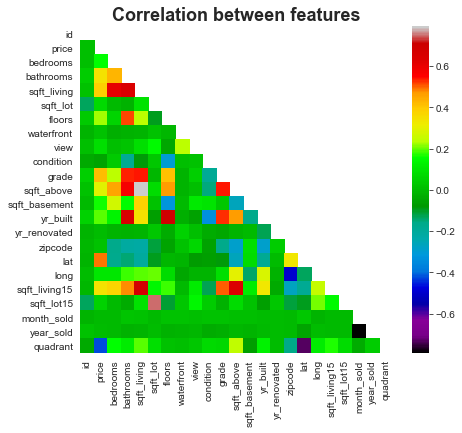

In [59]:
plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's drop columns that we won't be using or are causing some multicollinearity issues.
These columns will be:
* sqft_above
* month_sold (because we created seasons)
* zipcode (because we created quadrants)
* lat
* long 
* sqft_living15
* sqft_lot15

In [60]:
df.drop(columns= ['sqft_above', 'zipcode', 'month_sold', 'lat', 'long', 
                  'sqft_living15', 'sqft_lot15'], inplace= True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10674 entries, 0 to 21418
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10674 non-null  int64  
 1   price          10674 non-null  float64
 2   bedrooms       10674 non-null  int64  
 3   bathrooms      10674 non-null  float64
 4   sqft_living    10674 non-null  int64  
 5   sqft_lot       10674 non-null  int64  
 6   floors         10674 non-null  float64
 7   waterfront     10674 non-null  float64
 8   view           10674 non-null  float64
 9   condition      10674 non-null  int64  
 10  grade          10674 non-null  int64  
 11  sqft_basement  10674 non-null  float64
 12  yr_built       10674 non-null  int64  
 13  yr_renovated   10674 non-null  float64
 14  year_sold      10674 non-null  int64  
 15  season         10674 non-null  object 
 16  quadrant       10660 non-null  float64
dtypes: float64(8), int64(8), object(1)
memory usage: 1

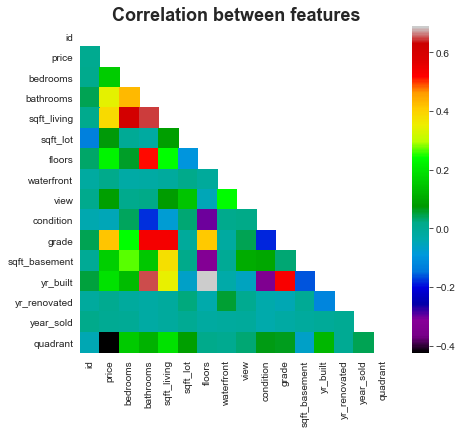

In [62]:
corr1 = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

### One-hot encoding, Integer encoding, and Dummy variables for categorical data

Okay. That second heatmap looks different than the one before! 

Time to work with the data within some of these features to clean it up.
Features we'll focus on are:
* bathrooms (integer)
* floors (integer)
* yr_built  (bin)
* sqft_basement (Y or N)
* view (Y or N)
* yr_renovated (Y or N)

In [ ]:
# Also, drop one from existing cat features: - use dummy variable
# waterfront
# condition
# grade
# quadrant

### Separate Continuous and Categorical Data

In [63]:
# # Continuous data
# con = ['sqft_living', 'yr_built', 'bathrooms', 'sqft_lot']
# df_con = df[con]

In [64]:
continuous = []
categorical = []

for col in df.columns:
    if (df[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [65]:
continuous

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_basement',
 'yr_built',
 'yr_renovated']

In [66]:
categorical

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'year_sold',
 'season',
 'quadrant']

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>]],
      dtype=object)

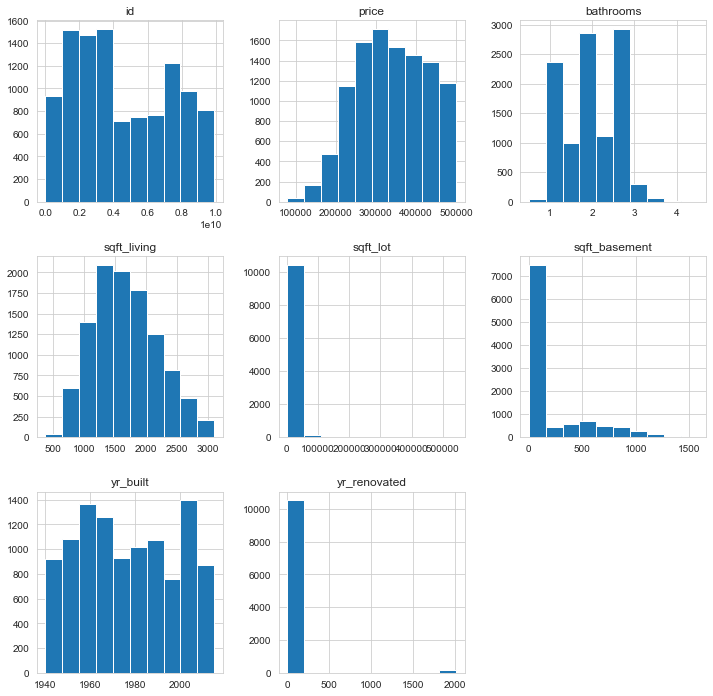

In [67]:
df_continuous = df.loc[:, continuous]
df_continuous.hist(figsize= (12, 12))

Difficult to see "sqft_lot" due to the scale of the graphs. Some of these look kind of normal-ish in their distribution.

In [68]:
# g = sns.pairplot(df[['price', 'sqft_living', 'yr_built','zipcode']], 
#                  hue= 'price', palette= 'deep', height= 5)

## Modeling and Prediction

### Baseline Model

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [71]:
df1 = df.copy()
outcome = 'price'
x_cols = df1.drop(['price', 'id', 'sqft_basement'], axis= 1).columns
x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'year_sold', 'season', 'quadrant'],
      dtype='object')

In [72]:
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df1).fit()

In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     595.0
Date:                Thu, 07 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:37:42   Log-Likelihood:            -1.3316e+05
No. Observations:               10660   AIC:                         2.664e+05
Df Residuals:                   10642   BIC:                         2.665e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.804e+07   4.62e+06     -6.065      0.000   -3.71e+07    -1.9e+07
season[T.spring]   4023.9101   2177.056      1.848      0.065    -243.526    8291.347
season[T.summer]   2212.6561   1990.312      1.112      0.266   -1688.728    6114.040
season[T.winter1] -3452.0489   2816.632     -1.226      0.220   -8973.173    2069.076
season[T.winter2] -1.024e+04   3123.384     -3.278      0.001   -1.64e+04   -4116.579
bedrooms          -6488.2424   1089.009     -5.958      0.000   -8622.904   -4353.581
bathrooms          1.501e+04   1697.043      8.843      0.000    1.17e+04    1.83e+04
sqft_living          53.1903      1.950     27.282      0.000      49.369      57.012
sqft_lot              0.3114      0.025     12.632      0.000       0.263       0.360
floors             1.268e+04   1634.291      7.759      0.000    9476.477    1.59e+04
waterfront         5.241e+04   2.35e+04      2.227      0.026    6289.937    9.85e+04
view               1.029e+04   1653.384      6.222      0.000    7045.876    1.35e+04
condition            1.2e+04   1114.340     10.769      0.000    9815.480    1.42e+04
grade              3.126e+04   1135.088     27.539      0.000     2.9e+04    3.35e+04
yr_built           -232.5185     50.082     -4.643      0.000    -330.688    -134.349
yr_renovated          8.6233      2.775      3.107      0.002       3.183      14.063
year_sold          1.418e+04   2296.003      6.178      0.000    9683.504    1.87e+04
quadrant          -4.363e+04    614.028    -71.057      0.000   -4.48e+04   -4.24e+04
==============================================================================
Omnibus:                        3.628   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.611
Skew:                           0.045   Prob(JB):                        0.164
Kurtosis:                       3.010   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Columns "floors" and "sqft_lot" have higher p-values than we'd like (< 0.05).

Baseline $R^{2}$ = 0.701

We can do some more cleaning and manipulating to get it better than that.

### Train test split

### Improving baseline model

In [ ]:
# get rid of columns you won't use
# https://www.youtube.com/watch?v=8_Le51miL-8
# https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [ ]:
# df2 = df1[['price', 'waterfront', 'yr_built', 'sqft_living15', 'zipcode']]

In [ ]:
# pd.plotting.scatter_matrix(df2, figsize= [11,11]);

In [ ]:
# df['zipcode'].hist()
# plt.show()

In [ ]:
# df.groupby('lat')['sqft_living'].mean().nlargest(5)
# df.groupby('lat')['sqft_living'].mean().min()
# df.groupby('long')['sqft_living'].mean().max()
# df.loc[(df['sqft_living'] <= 1200) & (df['sqft_living15'] > 2000)]
# df.loc[(df['sqft_living'] >= 3000)]
# df.groupby('long')['sqft_living'].mean().nlargest(5)

# for reference - delete when finished
# df_id_dups.groupby('date')['id'].count()
# df_id_dups= df_id_dups.groupby(['id']).unique().count()

In [ ]:
# create boxplot with all columns
# sns.boxplot(data=df, orient= 'h')

# # drop price, sqft_lot, zipcode, and sqft_lot15 to see rest of columns better
# boxplot_df.drop(['price', 'sqft_lot', 'sqft_lot15', 'zipcode'], axis= 1, inplace= True)

# # plot only one column in boxplot
# print (df['price'].nlargest(5))
# sns.boxplot(x= df['price'])

In [ ]:
# z test, z score
# How to remove everything after 2 standard deviations - can also use lambda
# df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]
# df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]

#can filter by column too - here "B" is name of column
# df[((df.B - df.B.mean()) / df.B.std()).abs() < 2]